In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Activation
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPool2D
from tensorflow.keras.models import Sequential
from keras.applications.vgg19 import VGG19 as PTM
from keras.applications.vgg16 import VGG16 as PreTrained
from keras.applications.vgg19 import  preprocess_input
from keras.applications.vgg16 import  preprocess_input
from tensorflow.keras import backend as bk
from tensorflow.keras.layers import BatchNormalization
import numpy as np
from tensorflow import keras
import glob
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
target_size= (224,224)
batch_size = 1
epochs = 10 * 3

In [5]:
train_path = 'Images/data/train'
val_path = 'Images/data/val'

In [ ]:
pip install keras==2.6.0

In [6]:
def get_class_name(path):
  class_name = os.path.basename(os.path.dirname(os.path.normpath(path)))
  return class_name

def create_confusion_matrics(true_value, pred_values):
  confusion_matrix_dl = confusion_matrix(true_value, pred_values)
  confusion_matrix_dl_df = pd.DataFrame(confusion_matrix_dl)
  plt.figure(figsize = (10,7))
  return sns.heatmap(confusion_matrix_dl_df, annot=True, cmap='Blues', fmt='g')

In [7]:
glob_train = glob.glob("{}/*/*".format(train_path))
glob_test  = glob.glob("{}/*/*".format(val_path))

In [8]:
training_data  = []
training_lable = []
print("Preparing Training Data...")
for train_path in tqdm(glob_train):
  img = tf.keras.preprocessing.image
  image = img.load_img(train_path, color_mode='rgb', target_size= target_size)
  image = np.array(image)
  class_name_train = get_class_name(train_path)
  training_data.append(image)
  training_lable.append(class_name_train)
print("Done Preparing Training Data.")


Preparing Training Data...



Done Preparing Training Data.


In [9]:
val_data  = []
val_lable = []
print("Preparing Testing Data...")
for test_path in tqdm(glob_test):
  img = tf.keras.preprocessing.image
  image = img.load_img(test_path, color_mode='rgb', target_size=target_size)
  image = np.array(image)
  class_name_val = get_class_name(test_path)
  val_data.append(image)
  val_lable.append(class_name_val)
print("Done Preparing Testing Data.")

Preparing Testing Data...



Done Preparing Testing Data.


<AxesSubplot:xlabel='label', ylabel='count'>

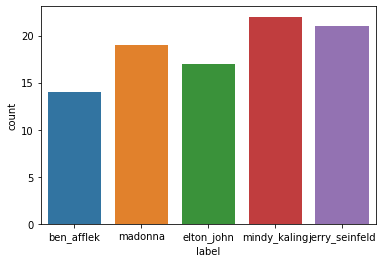

In [10]:
sns.countplot(pd.DataFrame(training_lable, columns=['label'])['label'])

<AxesSubplot:xlabel='label', ylabel='count'>

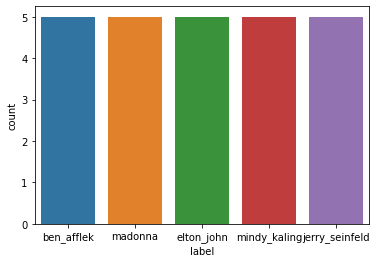

In [11]:
sns.countplot(pd.DataFrame(val_lable, columns=['label'])['label'])

In [12]:
encoder = LabelEncoder()
training_lable_cat = to_categorical(encoder.fit_transform(training_lable))
val_lable_cat = to_categorical(encoder.transform(val_lable))
classes = encoder.classes_
classes = list(classes)
classes

['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']

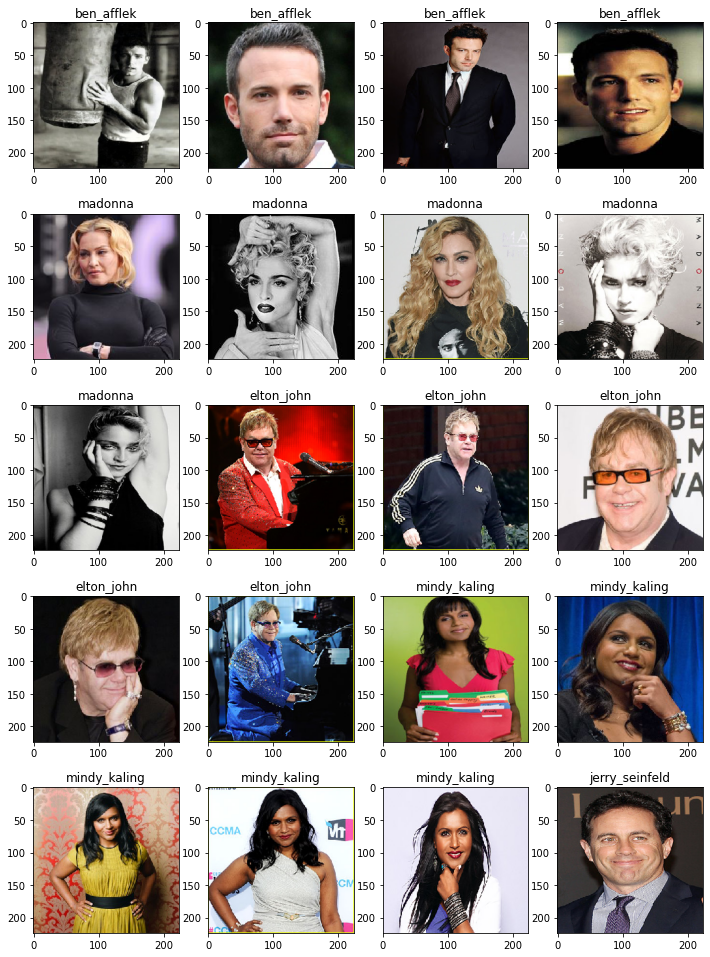

In [13]:
columns = 4
rows = 5
fig=plt.figure(figsize=(12, 17))
for i in range(1, columns*rows +1):  
  fig.add_subplot(rows, columns, i).set_title(val_lable[i])
  plt.imshow(val_data[i], cmap='gray')
plt.show()

In [14]:
augmented = []
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True, 
  vertical_flip=True,
	fill_mode="nearest")

In [15]:
print("Image Data Augmenting....")
for training_image in tqdm(training_data):
  img_expand = np.expand_dims(training_image, axis=0)
  aug_data = aug.flow(img_expand, batch_size=1)
  augmented.append(aug_data)
print("Done Image Data Augmenting.")

Image Data Augmenting....



Done Image Data Augmenting.


In [16]:
training_data_augmented = []
training_data_lable_cat = []
print("Generaring Data...")
for i in tqdm(range(len(augmented))):
  lable = training_lable_cat[i]
  img_aug_data = augmented[i]
  for i in range(25):
    batch = img_aug_data.next()
    image = batch[0].astype('uint8')
    image = np.array(image)
    training_data_augmented.append(image)
    training_data_lable_cat.append(lable)
print("Generaring Data Done.")

Generaring Data...



Generaring Data Done.


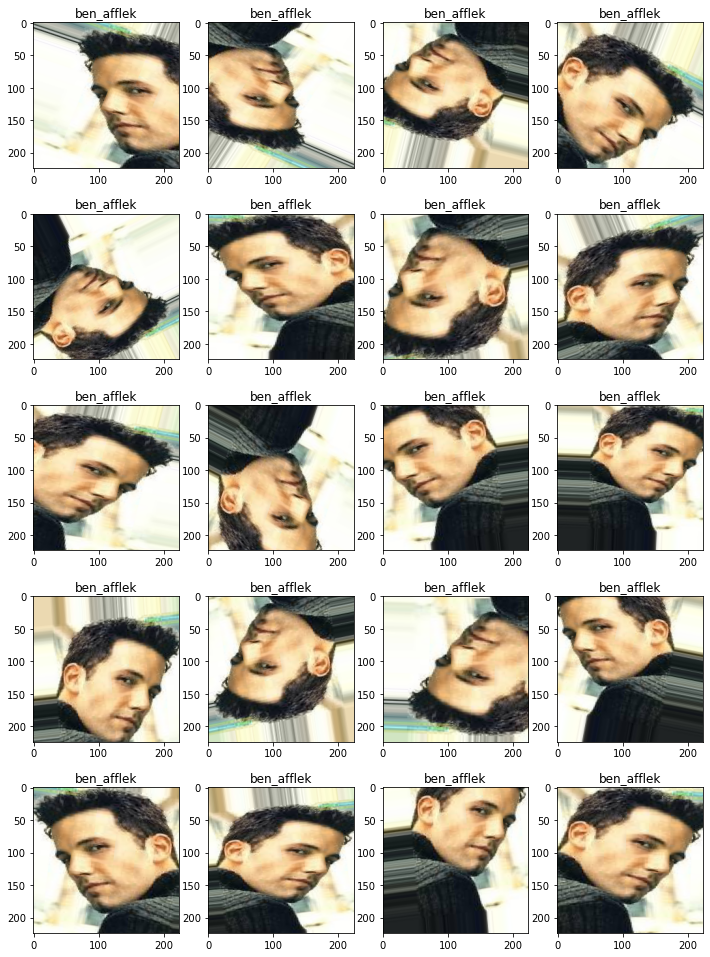

In [17]:
columns = 4
rows = 5
fig=plt.figure(figsize=(12, 17))
for i in range(1, columns*rows +1):  
  fig.add_subplot(rows, columns, i).set_title(classes[np.argmax(training_data_lable_cat[i])])
  plt.imshow(training_data_augmented[i], cmap='gray')
plt.show()

<AxesSubplot:xlabel='label', ylabel='count'>

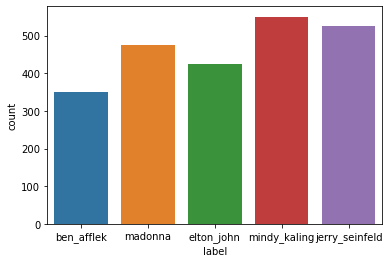

In [18]:
lbls = [classes[np.argmax(lbl)] for lbl in training_data_lable_cat]
sns.countplot(pd.DataFrame(lbls, columns=['label'])['label'])

In [19]:
pd.DataFrame(lbls, columns=['label'])['label'].value_counts()

mindy_kaling      550
jerry_seinfeld    525
madonna           475
elton_john        425
ben_afflek        350
Name: label, dtype: int64

In [20]:
ptm = PTM(weights='imagenet', 
            include_top=False, pooling='avg')
ptm.trainable = False

2022-03-22 04:36:18.385014: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


80150528/80134624 [==============================] - 9s 0us/step


In [21]:
training_features = []
print("Extracting Training Features ...")
for image in tqdm(training_data_augmented):
  img = np.expand_dims(image, axis=0)
  training_feature = ptm.predict(preprocess_input(img))[0]
  training_features.append(training_feature)
print("Done Extracting Training Features.")

Extracting Training Features ...


2022-03-22 04:36:35.398184: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)



Done Extracting Training Features.


In [22]:
training_features_df = pd.DataFrame(training_features)
training_features_df.head()

0         1         2         3         4         5         6    \
0  0.000000  0.631887  1.412262  0.121885  0.268376  0.209591  0.375225   
1  0.000000  0.147311  0.383478  0.000000  0.314673  1.059215  0.347989   
2  3.748014  0.649943  1.635641  4.493024  0.083669  5.083151  3.141281   
3  6.055725  0.000000  0.401514  1.235098  0.041182  2.603107  0.633451   
4  0.000000  0.474047  2.157203  0.000225  0.329690  0.426107  0.183967   

        7         8         9    ...       502       503       504       505  \
0  0.000000  0.710121  0.013752  ...  2.099786  0.737293  0.185153  0.459754   
1  0.122518  0.437663  1.055966  ...  2.083683  0.607330  0.331428  0.000000   
2  0.000000  1.623321  0.451233  ...  1.107655  1.975779  1.127275  0.722345   
3  0.000000  1.287059  0.390160  ...  5.583579  1.267092  1.542135  3.793684   
4  0.069838  2.166447  0.000000  ...  1.308617  1.388230  0.186453  0.722877   

         506       507       508        509       510       511  
0  17.080597  5.866966  0.128371   7.200281  2.397974  0.688729  
1   8.154645  2.882165  0.889439   3.173558  5.921418  0.000000  
2   6.839974  2.612184  3.108322  10.627284  4.207173  0.814111  
3  13.694844  2.314773  4.071908  15.865805  2.832830  0.146621  
4   2.945172  5.509593  0.134446   8.912108  4.238563  0.779332  

[5 rows x 512 columns]

In [23]:
training_features_df.shape

(2325, 512)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(training_features_df.values, np.asarray(training_data_lable_cat), test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1627, 512), (698, 512), (1627, 5), (698, 5))

In [25]:
n_classes = len(pd.DataFrame(lbls, columns=['label'])['label'].unique())
n_classes

5

In [26]:
model_wod = Sequential([
    Dense(1024, input_shape=(512,)),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, input_shape=(512,)),
    Activation('relu'),
    Dense(n_classes),
    Activation('softmax'),
])

model_wod.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
model_wod.fit(X_train, y_train, epochs=10, batch_size=5, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
326/326 [==============================] - 4s 8ms/step - loss: 0.6298 - accuracy: 0.7910 - val_loss: 0.4259 - val_accuracy: 0.8854
Epoch 2/10
326/326 [==============================] - 3s 9ms/step - loss: 0.2695 - accuracy: 0.9084 - val_loss: 0.0964 - val_accuracy: 0.9685
Epoch 3/10
326/326 [==============================] - 2s 7ms/step - loss: 0.2350 - accuracy: 0.9213 - val_loss: 0.0803 - val_accuracy: 0.9613
Epoch 4/10
326/326 [==============================] - 3s 8ms/step - loss: 0.1617 - accuracy: 0.9459 - val_loss: 0.0279 - val_accuracy: 0.9900
Epoch 5/10
326/326 [==============================] - 3s 9ms/step - loss: 0.1899 - accuracy: 0.9428 - val_loss: 0.0419 - val_accuracy: 0.9814
Epoch 6/10
326/326 [==============================] - 2s 7ms/step - loss: 0.1213 - accuracy: 0.9625 - val_loss: 0.0218 - val_accuracy: 0.9900
Epoch 7/10
326/326 [==============================] - 2s 7ms/step - loss: 0.0975 - accuracy: 0.9650 - val_loss: 0.0104 - val_accuracy: 0.9957
Epoch 

In [28]:
model_wod.evaluate(X_test, y_test)

22/22 [==============================] - 0s 7ms/step - loss: 0.0045 - accuracy: 0.9971


[0.0044845156371593475, 0.9971346855163574]

In [29]:
model_wod_pred = model_wod.predict(X_test)

In [30]:
actual_y_test = []
pred_y_test = []
for y_cat in y_test:
  actual_y_test.append(np.argmax(y_cat))

for y_pred_cat in model_wod_pred:
  pred_y_test.append(np.argmax(y_pred_cat))

<AxesSubplot:>

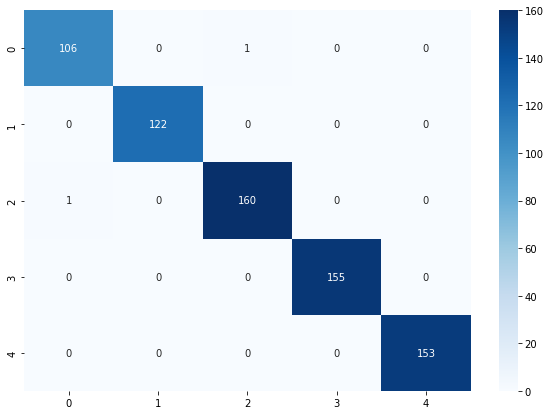

In [31]:
create_confusion_matrics(actual_y_test, pred_y_test)


In [32]:
valadition_set_attr = []
print("Extracting Testing Features...")
for val_image in tqdm(val_data):
  val_img = np.expand_dims(val_image, axis=0)
  val_attr = ptm.predict(preprocess_input(val_img))[0]
  valadition_set_attr.append(val_attr)
print("Done Extracting Testing Features.")


Extracting Testing Features...



Done Extracting Testing Features.


In [33]:
pd.DataFrame(valadition_set_attr).head()

0         1    2         3         4         5         6         7    \
0  0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.536847  1.230762  0.0  0.136716  0.000000  1.565864  2.525462  0.016536   
2  0.000000  0.000000  0.0  0.000000  0.224018  0.000000  0.000000  0.424141   
3  0.000000  0.000000  0.0  0.000000  0.225251  0.000000  0.000000  0.000000   
4  0.484365  0.000000  0.0  0.000000  0.000000  0.000000  0.399560  0.238444   

        8         9    ...       502       503       504       505       506  \
0  0.000000  0.103654  ...  0.394648  0.998397  0.640987  0.000000  0.325807   
1  1.186177  3.957816  ...  2.198987  2.187089  0.319581  3.275132  0.588804   
2  0.000000  0.957141  ...  2.945100  0.285393  0.062412  0.000000  0.915973   
3  0.250528  0.000000  ...  0.016638  1.226777  1.126467  0.000000  1.680138   
4  0.091995  0.000000  ...  2.133585  0.123503  0.125454  0.000000  1.806619   

        507       508        509       510       511  
0  0.000000  0.014447   0.177602  0.612992  0.629301  
1  0.350736  0.359171  10.379569  0.563302  1.309840  
2  0.000000  0.000000   3.152311  0.037815  4.183078  
3  0.000000  0.000000   0.253753  0.458201  1.524866  
4  0.258340  0.000000   7.157215  0.651901  0.644774  

[5 rows x 512 columns]

In [34]:
val_attr_data = np.asarray(valadition_set_attr)

In [35]:
val_pred = model_wod.predict(val_attr_data)

In [36]:
pred_df = pd.DataFrame([[np.argmax(pred), classes[np.argmax(pred)]] for pred in val_pred], columns=['Pred', 'Celebrity Name'])
pred_df['val_lable'] = val_lable

In [37]:
print(classification_report(np.asarray([np.argmax(p) for p in val_lable_cat]), pred_df['Pred'].values))

              precision    recall  f1-score   support

           0       0.43      0.60      0.50         5
           1       0.80      0.80      0.80         5
           2       0.67      0.40      0.50         5
           3       0.71      1.00      0.83         5
           4       1.00      0.60      0.75         5

    accuracy                           0.68        25
   macro avg       0.72      0.68      0.68        25
weighted avg       0.72      0.68      0.68        25



<AxesSubplot:>

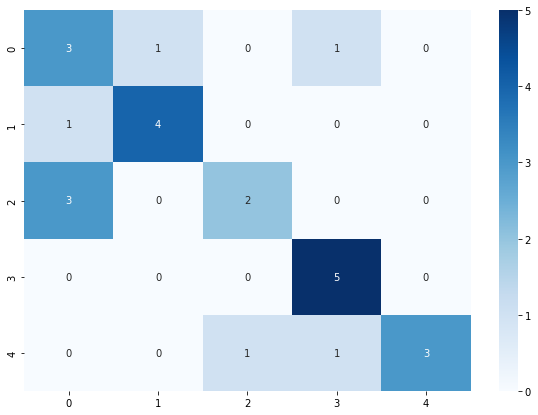

In [38]:
create_confusion_matrics(np.asarray([np.argmax(p) for p in val_lable_cat]), pred_df['Pred'].values)

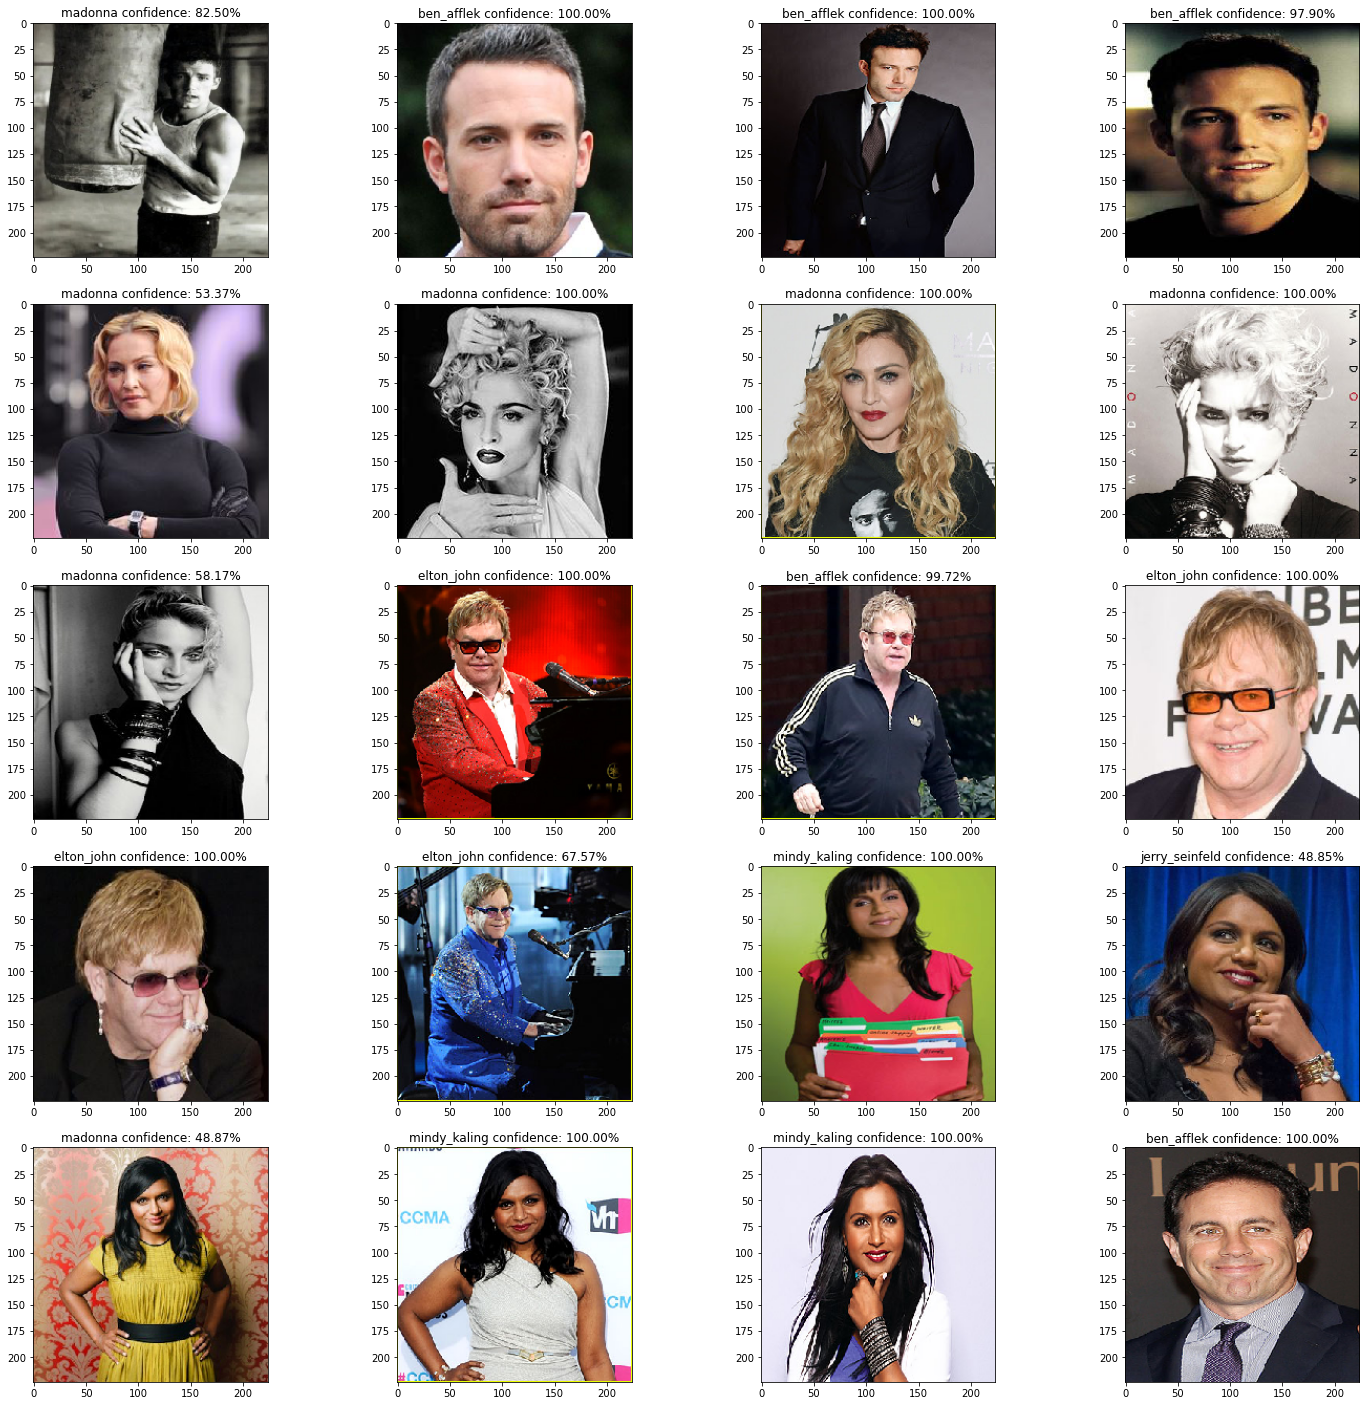

In [39]:
columns = 4
rows = 5
fig=plt.figure(figsize=(25, 25))
for i in range(1, columns*rows +1):
  pred = np.argmax(val_pred[i])
  confidance =  val_pred[i][pred] * 100
  person = classes[pred]
  message = "{} confidence: {:.2f}%".format(person, float(confidance))
  fig.add_subplot(rows, columns, i).set_title(message)
  plt.imshow(val_data[i], cmap='gray')

In [50]:
Pkl_Filename = "Pickle_RL_Model.pkl"  

model_wod.save("save.h5", save_format='h5')

2022-03-22 05:29:33.155500: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: save.sav/assets
